#**Predict California Housing Prices**
By Daisy Khamphakdy

Goal:
*   Given a number of features / characteristics of California houses, predict the approximate house price.


Method:

Since this dataset is dealing with continuous variables, we use the appropriate models below:
*   Linear regression
*   Random Forest + GridSearchCV

##Import libraries and packages

In [126]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [93]:
from google.colab import drive

drive.mount('/content/gdrive')

# load dataset
df_raw = pd.read_csv('/content/gdrive/My Drive/1.1 DS Projects/House Sales/housing.csv')
df = df_raw.copy(deep=True)

# preview of dataset
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


First, we can already see that ocean_proximity is categorical which the model cannot read. So we will eventually need to process it and scale it to be numerical for the ML model.

##EDA

In [94]:
#see if we have any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Most of the values are 20640, indicating that many are not null, but total_bedrooms is 20433, so we will have to drop the NaN values.

In [95]:
# drop the NaN values and use inplace=true to save it to the dataframe.
df.dropna(inplace=True)

In [96]:
#now we can see they're all 20433, so non null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


##Train (X) and Test (y) data

In [97]:
#our X will be median
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

In [98]:
# you can see that X is the entire dataframe minus the median_house_value column
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,INLAND


In [99]:
# as you can see, y (our target label) is this column median_house_value
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20433, dtype: float64

In [100]:
#Split train and test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2)

In [101]:
#we have the train dataframe only
train_data = X_train.join(y_train)
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
3545,-118.63,34.24,9.0,4759.0,924.0,1884.0,915.0,4.8333,<1H OCEAN,277200.0
13075,-121.29,38.59,19.0,2460.0,470.0,1346.0,480.0,3.6563,INLAND,95600.0
10636,-117.79,33.70,6.0,1593.0,371.0,832.0,379.0,4.4286,<1H OCEAN,239500.0
6419,-118.01,34.15,32.0,6597.0,1579.0,3689.0,1459.0,3.2377,INLAND,184100.0
1939,-120.95,38.69,10.0,3421.0,563.0,1689.0,545.0,5.2032,INLAND,217100.0
...,...,...,...,...,...,...,...,...,...,...
4676,-118.34,34.07,52.0,2066.0,319.0,981.0,297.0,5.8632,<1H OCEAN,450000.0
6799,-118.11,34.10,44.0,2012.0,435.0,1454.0,456.0,3.3229,<1H OCEAN,226600.0
15979,-122.45,37.76,31.0,5283.0,1330.0,2659.0,1269.0,3.5744,NEAR BAY,500000.0
10820,-117.92,33.65,15.0,1309.0,477.0,1330.0,424.0,3.4417,<1H OCEAN,182500.0


##EDA of Train data

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

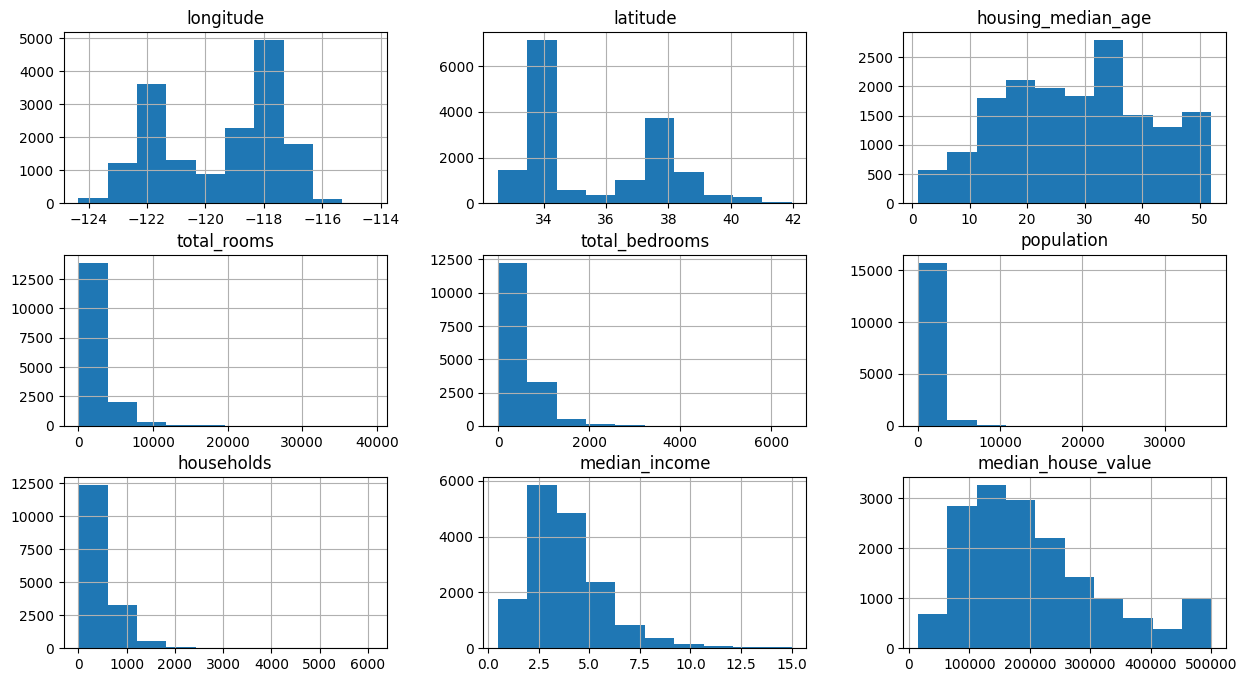

In [102]:
# you can use histogram to see the distribution of various features and and correlation with the target variable.
train_data.hist(figsize= (15, 8))

Now you can use histogram to see the distribution of various features and and correlation with the target variable.

<ipython-input-103-72e5073b8efe>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu') #.corr() shows a correlation heatmap; cmap is the color map for yellow, green, blue


<Axes: >

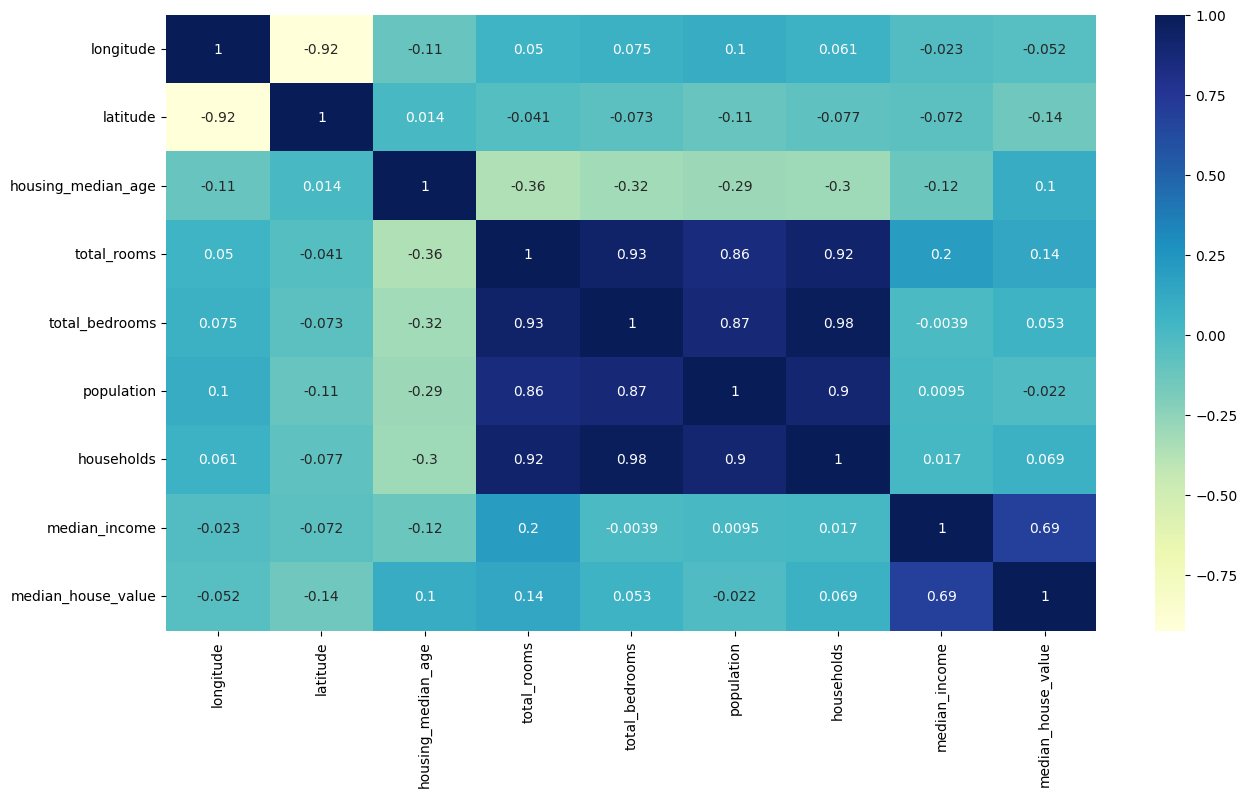

In [103]:
#Use heatmap to visualize correlation matrix. Correlation matrix allows us to see the relationship between two variables.
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu') #.corr() shows a correlation heatmap; cmap is the color map for yellow, green, blue

In [104]:
#this is the same correlation matrix above without the heatmap.
train_data.corr()

<ipython-input-104-9d985d5d4cbd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924852,-0.110587,0.049509,0.074805,0.101762,0.060838,-0.022958,-0.051613
latitude,-0.924852,1.000000,0.013711,-0.041354,-0.072615,-0.111422,-0.077370,-0.072213,-0.138018
housing_median_age,-0.110587,0.013711,1.000000,-0.361546,-0.320919,-0.294955,-0.302406,-0.124812,0.103869
total_rooms,0.049509,-0.041354,-0.361546,1.000000,0.930150,0.855433,0.918128,0.202023,0.138360
total_bedrooms,0.074805,-0.072615,-0.320919,0.930150,1.000000,0.873828,0.978716,-0.003912,0.052859
population,0.101762,-0.111422,-0.294955,0.855433,0.873828,1.000000,0.904493,0.009484,-0.022011
households,0.060838,-0.077370,-0.302406,0.918128,0.978716,0.904493,1.000000,0.017494,0.068718
median_income,-0.022958,-0.072213,-0.124812,0.202023,-0.003912,0.009484,0.017494,1.000000,0.690353
median_house_value,-0.051613,-0.138018,0.103869,0.138360,0.052859,-0.022011,0.068718,0.690353,1.000000


## Data Preprocessing

- As you can see from the histograms, some are heavily right skewed and it's not a nice Gaussian bell curve, so we're going to take the logarithm of those features and see what the distribution looks like using that. logarithmic transformation is commonly used to reduce the skewness of data. It involves taking the logarithm of the values in a dataset. This transformation is particularly useful when dealing with data that has a right-skewed distribution, where the majority of the data points are concentrated towards the lower end of the scale.

In [105]:
# we use the logarithm to balance data so it's not as right skewed and more normal
train_data['total_rooms'] = np.log(train_data['total_rooms']+1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms']+1)
train_data['population'] = np.log(train_data['population']+1)
train_data['households'] = np.log(train_data['households']+1)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

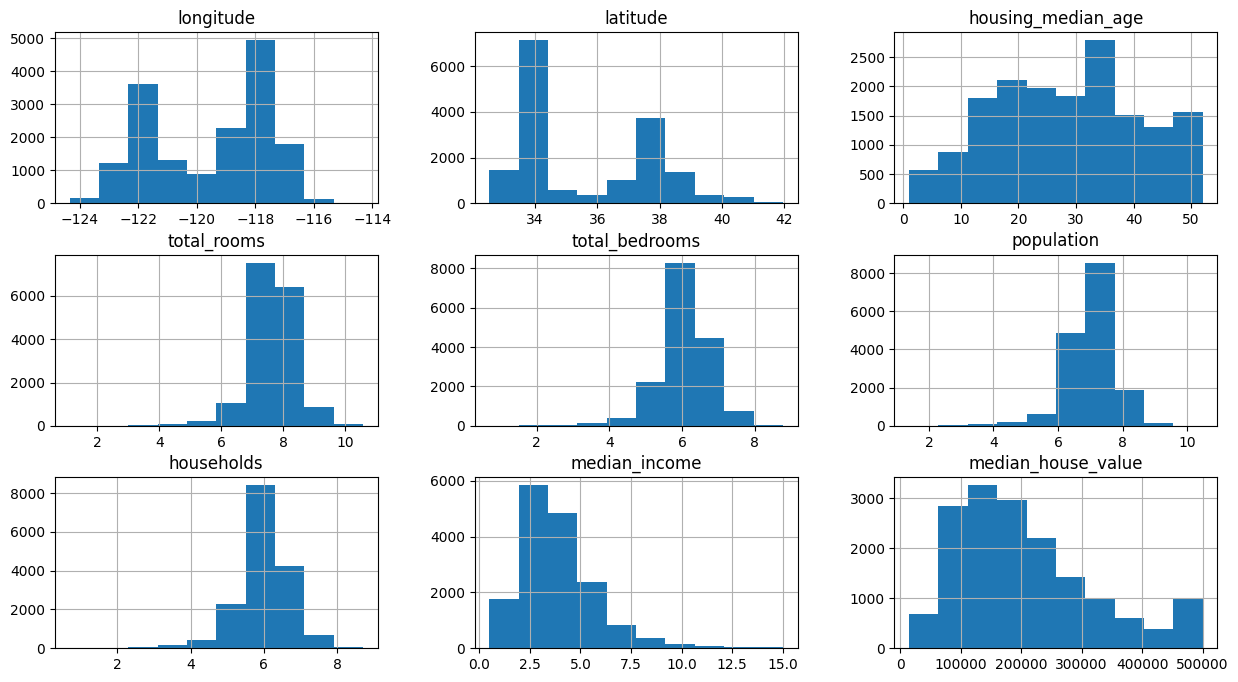

In [106]:
#now, let's view the histograms again but with logarthmic applied
train_data.hist(figsize= (15, 8))

Now, let's view the histograms again but with logarthmic applied. You can see the four right skewed columns are closer to a normal (Gaussian bell curve) distribution.

Now, let's fix the ocean_proximity - because this is valuable data. We can assume that being closer to the ocean will yield higher house value.
- Because ML models cannot take in categorical features, we have to turn it into a numerical value. For categorical features, it's not best to apply ordinal features
- Ordinal encoding - each unique category value is assigned an integer value. For example, “red” is 1, “green” is 2, and “blue” is 3.
- One-Hot Encoding - For categorical variables where no ordinal relationship exists, the integer encoding may not be enough, at best, or misleading to the model at worst. One-hot encoding is a method that transforms categorical variables into a binary matrix where each category is represented as a column, and each instance is marked with a ‘1’ in the corresponding column and ‘0’ in all other columns. This technique is particularly useful when dealing with nominal variables, where there is no inherent order among categories.

In [107]:
train_data.ocean_proximity.value_counts()

<1H OCEAN     7252
INLAND        5164
NEAR OCEAN    2125
NEAR BAY      1801
ISLAND           4
Name: ocean_proximity, dtype: int64

So instead of

1H OCEAN     = 1 >> yes (1) or no (0)

INLAND        = 2

NEAR OCEAN    = 3

NEAR BAY      = 4

ISLAND         = 5

In [108]:
# pandas.get_dummies() is one hot-encoding and used for data manipulation. It converts categorical data into dummy or indicator variables.
pd.get_dummies(train_data.ocean_proximity)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
3545,1,0,0,0,0
13075,0,1,0,0,0
10636,1,0,0,0,0
6419,0,1,0,0,0
1939,0,1,0,0,0
...,...,...,...,...,...
4676,1,0,0,0,0
6799,1,0,0,0,0
15979,0,0,0,1,0
10820,1,0,0,0,0


In [109]:
#now we add the one hot encoded column of ocean_proximity back into train_data and remove the column with the categorical variable
train_data = train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

In [110]:
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
3545,-118.63,34.24,9.0,8.468003,6.829794,7.541683,6.820016,4.8333,277200.0,1,0,0,0,0
13075,-121.29,38.59,19.0,7.808323,6.154858,7.205635,6.175867,3.6563,95600.0,0,1,0,0,0
10636,-117.79,33.70,6.0,7.374002,5.918894,6.725034,5.940171,4.4286,239500.0,1,0,0,0,0
6419,-118.01,34.15,32.0,8.794522,7.365180,8.213382,7.286192,3.2377,184100.0,0,1,0,0,0
1939,-120.95,38.69,10.0,8.137980,6.335054,7.432484,6.302619,5.2032,217100.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,-118.34,34.07,52.0,7.633854,5.768321,6.889591,5.697093,5.8632,450000.0,1,0,0,0,0
6799,-118.11,34.10,44.0,7.607381,6.077642,7.282761,6.124683,3.3229,226600.0,1,0,0,0,0
15979,-122.45,37.76,31.0,8.572439,7.193686,7.886081,7.146772,3.5744,500000.0,0,0,0,1,0
10820,-117.92,33.65,15.0,7.177782,6.169611,7.193686,6.052089,3.4417,182500.0,1,0,0,0,0


We can see the one-hot encoded features toward the right of the table

<Axes: >

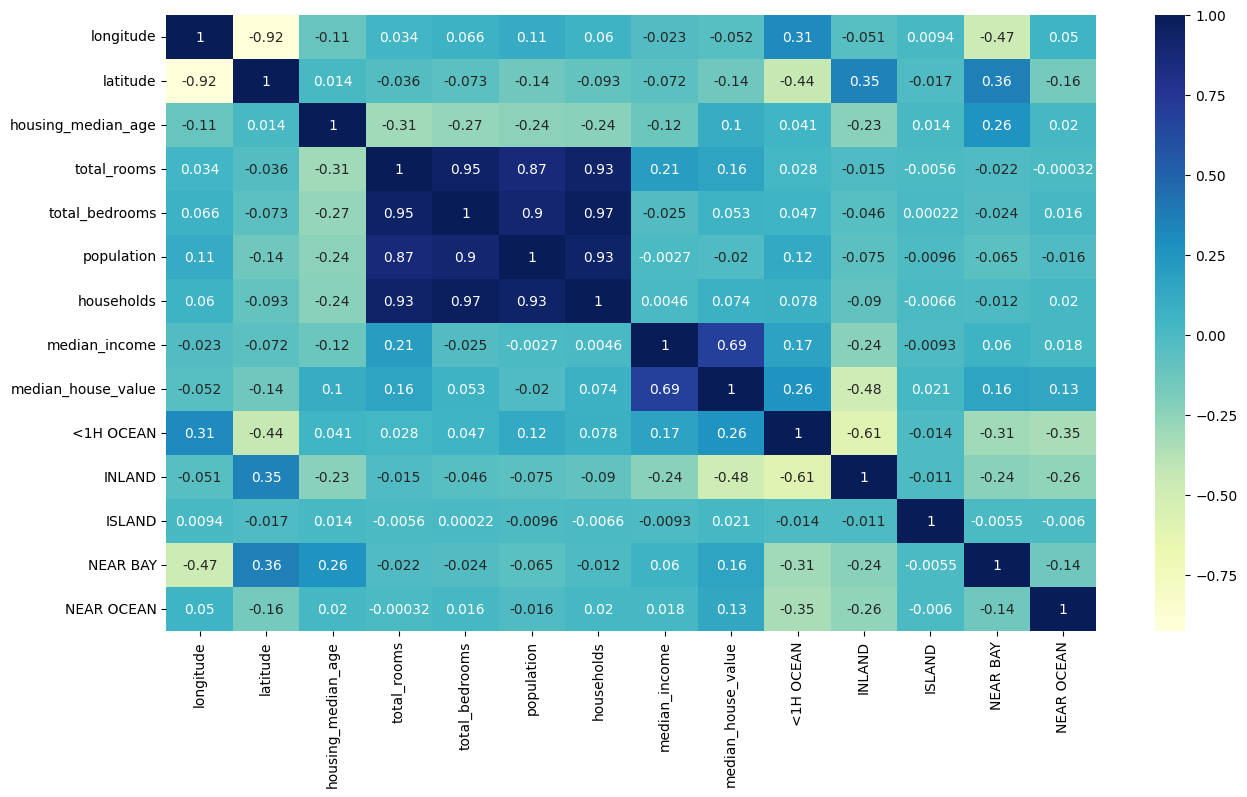

In [111]:
#Let's look at the heatmap again to see if there's any correlation
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')

<Axes: xlabel='latitude', ylabel='longitude'>

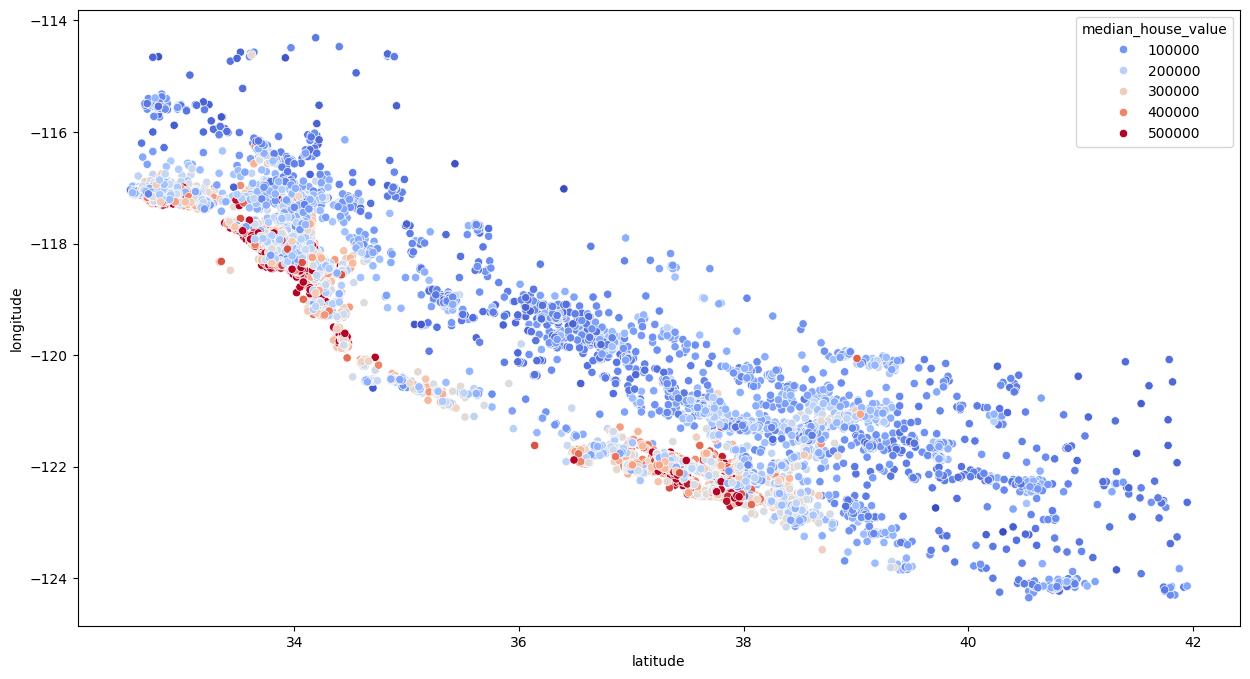

In [112]:
# let's visualize the coordinates

plt.figure(figsize=(15,8))
sns.scatterplot(data=train_data, x='latitude', y='longitude', hue='median_house_value', palette='coolwarm')

In [135]:
import io
import urllib.request
from PIL import Image
import matplotlib.image as mpimg

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename

with urllib.request.urlopen(url) as url_request:
    image_data = url_request.read()

image_data = io.BytesIO(image_data)
california_img = mpimg.imread(image_data, format='png')

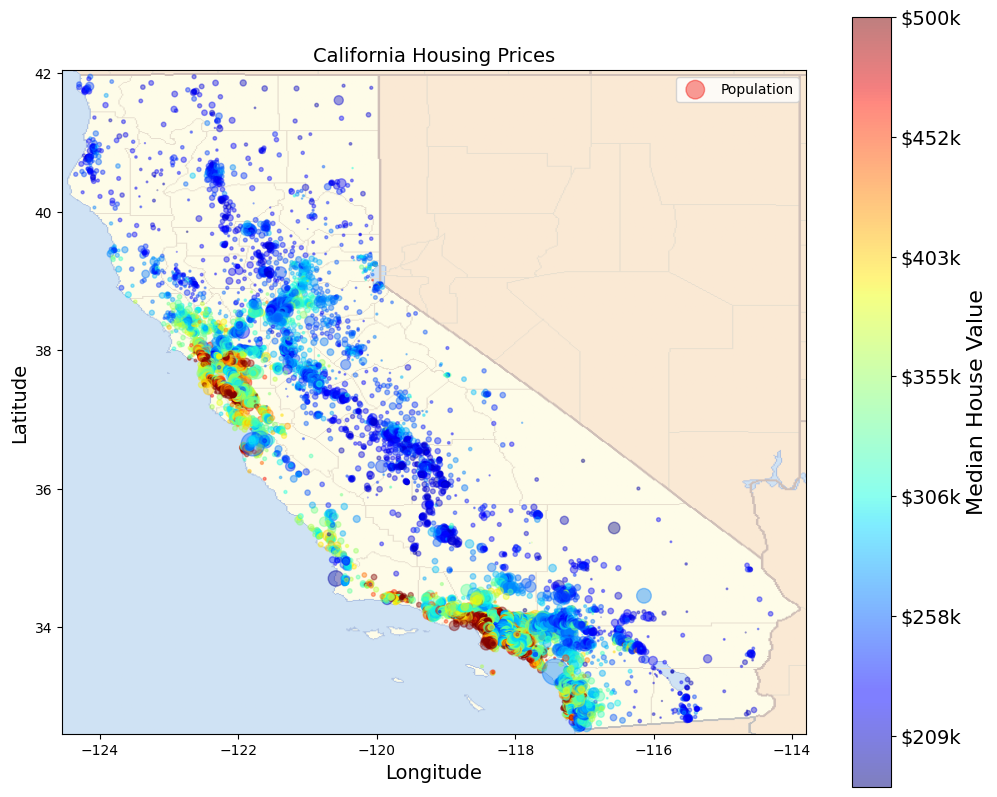

In [136]:
ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,10),
                  s=df['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.title("California Housing Prices", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.show()

You can see that red are higher prices and blue are less. While it's not exactly the CA coast, taking in latitude and longitude, the scatterplot almost creates the coastal line. Red indicates more expensive homes closer to the coast.

## Feature engineering

- There are some features we may want to combine. E.g. We have rooms and bedrooms - we may want to see how many of those bedrooms are rooms.

In [113]:
# this identifies how many of the rooms are bedrooms
train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']

#if you have more houses in a block, likely equals to more rooms - so this identifies how many of the rooms there are
train_data['household_rooms'] = train_data['total_rooms'] / train_data['households']

<Axes: >

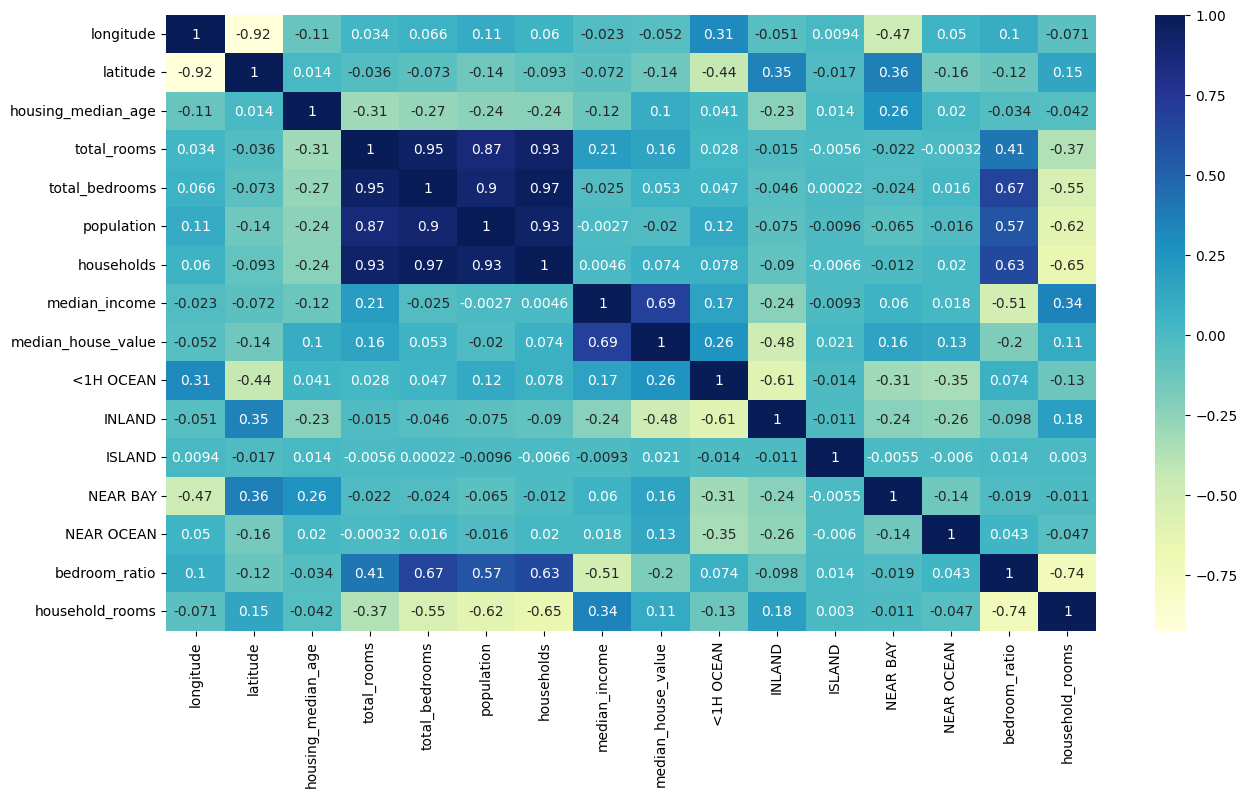

In [114]:
#Let's look at the heatmap again to see if there's any correlation
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')

With this heatmap, you can see the bedroom_ratio with median_house_value (0.027)does not have a high correlation. Same with household_rooms and median_house_value.
- In the future, we can also drop features we don't believe is valuable as that will help with the modeling.

##ML Models

###Linear Regression
- Linear regression is more a statistical model than ML model, but we can apply a simple linear regression model for what we're trying to solve for right now.

In [115]:
X_train, y_train = train_data.drop(['median_house_value'], axis=1), train_data['median_house_value']

In [116]:
# creating a regression model
model = LinearRegression()

# fitting the model
model.fit(X_train,y_train)

LinearRegression()

In [117]:
#Now we have to see how well the linear regression model trained and compare it to the test data.
# we split train and test data a bit too early, so we copy and paste what we did earlier with the codes
# and apply it to the test data here.

test_data = X_test.join(y_test)

# we use the logarithm to balance data so it's not as right skewed and more normal
test_data['total_rooms'] = np.log(test_data['total_rooms']+1)
test_data['total_bedrooms'] = np.log(test_data['total_bedrooms']+1)
test_data['population'] = np.log(test_data['population']+1)
test_data['households'] = np.log(test_data['households']+1)

#now we add the one hot encoded column of ocean_proximity back into train_data and remove the column with the categorical variable
test_data = test_data.join(pd.get_dummies(test_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

# this identifies how many of the rooms are bedrooms
test_data['bedroom_ratio'] = test_data['total_bedrooms'] / test_data['total_rooms']
#if you have more houses in a block, likely equals to more rooms - so this identifies how many of the rooms there are
test_data['household_rooms'] = test_data['total_rooms'] / test_data['households']



In [118]:
X_test, y_test = test_data.drop(['median_house_value'], axis=1), test_data['median_house_value']

Now we have to see how well the linear regression model trained and compare it to the test data. We split train and test data a bit too early, so we copy and paste what we did earlier with the codes and apply it to the test data here.

In [119]:
test_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,household_rooms
19462,-120.99,37.68,30.0,7.588830,5.929589,6.597146,5.789960,2.6932,94900.0,0,1,0,0,0,0.781358,1.310688
2183,-120.21,36.77,20.0,7.465083,5.855072,6.997596,5.713733,2.3194,90600.0,0,1,0,0,0,0.784328,1.306516
1814,-122.31,37.91,43.0,7.843849,6.238325,6.966967,6.270988,3.6417,178400.0,0,0,0,1,0,0.795314,1.250815
11777,-121.27,38.75,43.0,7.164720,5.730100,6.473891,5.521461,2.7188,85300.0,0,1,0,0,0,0.799766,1.297613
17691,-121.83,37.30,17.0,7.170120,5.356586,6.716595,5.384495,4.5000,235800.0,1,0,0,0,0,0.747071,1.331623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12375,-116.38,33.74,7.0,9.774517,8.154788,8.183677,7.507141,4.0840,194500.0,0,1,0,0,0,0.834291,1.302029
16964,-122.31,37.53,41.0,7.383368,5.598422,6.517671,5.590987,4.6125,361700.0,0,0,0,0,1,0.758248,1.320584
1422,-122.05,38.00,36.0,7.814803,6.159095,7.101676,5.976351,3.7333,136400.0,0,0,0,1,0,0.788132,1.307621
6426,-117.99,34.13,37.0,7.358194,5.918894,7.389564,5.860786,2.9605,129400.0,0,1,0,0,0,0.804395,1.255496


In [120]:
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,household_rooms
3545,-118.63,34.24,9.0,8.468003,6.829794,7.541683,6.820016,4.8333,277200.0,1,0,0,0,0,0.806541,1.241640
13075,-121.29,38.59,19.0,7.808323,6.154858,7.205635,6.175867,3.6563,95600.0,0,1,0,0,0,0.788243,1.264328
10636,-117.79,33.70,6.0,7.374002,5.918894,6.725034,5.940171,4.4286,239500.0,1,0,0,0,0,0.802671,1.241379
6419,-118.01,34.15,32.0,8.794522,7.365180,8.213382,7.286192,3.2377,184100.0,0,1,0,0,0,0.837474,1.207012
1939,-120.95,38.69,10.0,8.137980,6.335054,7.432484,6.302619,5.2032,217100.0,0,1,0,0,0,0.778455,1.291206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,-118.34,34.07,52.0,7.633854,5.768321,6.889591,5.697093,5.8632,450000.0,1,0,0,0,0,0.755624,1.339956
6799,-118.11,34.10,44.0,7.607381,6.077642,7.282761,6.124683,3.3229,226600.0,1,0,0,0,0,0.798914,1.242086
15979,-122.45,37.76,31.0,8.572439,7.193686,7.886081,7.146772,3.5744,500000.0,0,0,0,1,0,0.839164,1.199484
10820,-117.92,33.65,15.0,7.177782,6.169611,7.193686,6.052089,3.4417,182500.0,1,0,0,0,0,0.859543,1.186001


In [121]:
model.score(X_test, y_test)

0.6619122653767889

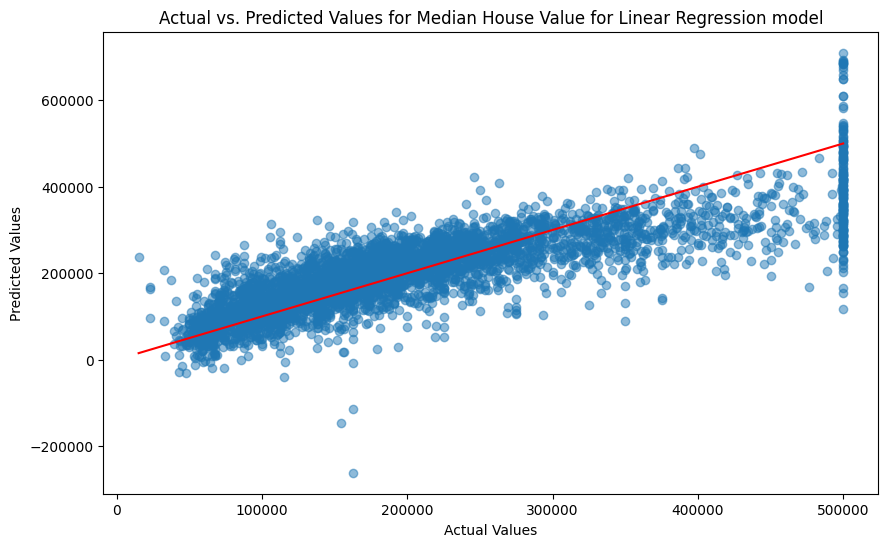

In [138]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Median House Value for Linear Regression model')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

model.score automates the prediction of the data using X_test and compares it with y_test and by default uses the R-squared metric to so (hence don't need to manually derive y_pred).

0.67 is not the greatest score. We can expect to have a higher score with random forest.

###Random Forest

In [123]:
random_forest_model = RandomForestRegressor()

random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [125]:
random_forest_model.score(X_test,y_test)

0.8096374764317629

While 0.8 is a much higher accuracy score, we can do better. So let's try gridsearch with cross validation.
- Cross validation K-fold:  In K-Fold CV, we further split our training set into K number of subsets, called folds. We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold (called the validation data). As an example, consider fitting a model with K = 5. The first iteration we train on the first four folds and evaluate on the fifth. The second time we train on the first, second, third, and fifth fold and evaluate on the fourth. We repeat this procedure 3 more times, each time evaluating on a different fold. At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.
- For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings.

In [130]:
# we need to provide a parameter
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_features': [2, 4, 6, 8]
}

#now we do the grid search. We include the model; grid search; the cross validation amount;
#we need a more positive score so more positive, the better;
grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)

#then we want to fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [132]:
best_forest = grid_search.best_estimator_

In [133]:
best_forest.score(X_test, y_test)

0.8032075113179558

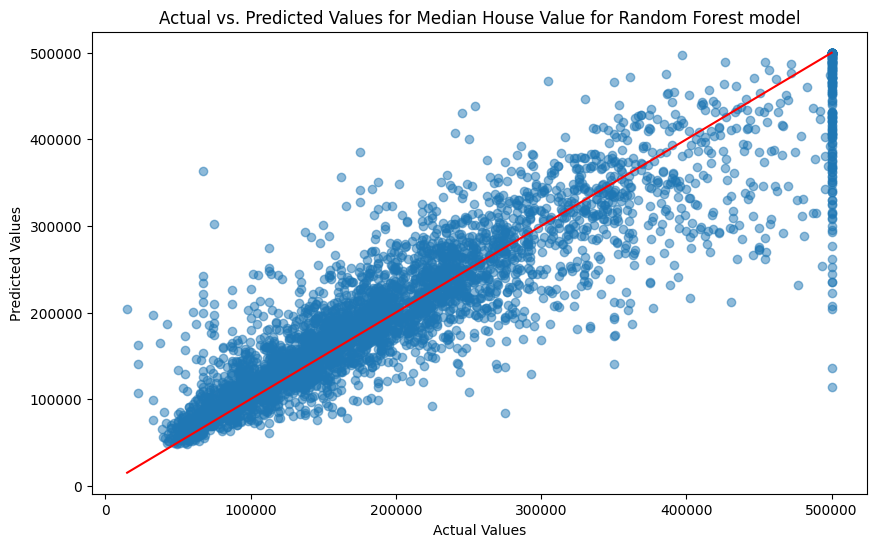

In [140]:
y_pred = random_forest_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Median House Value for Random Forest model')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

- From the scatter plot along with the accuracy score, we can see that Random Forest performed better than the Linear Regression model. The line is fit more perfectly onto the scatterplot.
- However, the accuracy score for Random Forest did not improve (0.803 vs 0.809) that much with hyperparameter tuning (what we did with grid search cross validation). So we can continue to adjust estimators, max features, etc., until we feel comfortable with our accuracy score.